# Collecting data

In [1]:
from __future__ import print_function
import pandas as pd 
import numpy as np 
#!pip install arrow
import arrow
#!pip install quandl
import quandl     
import pickle
from datetime import datetime
import matplotlib.pyplot as plt 
import re
%matplotlib inline

import seaborn as sb
sb.set_style("white")

In [2]:
#Features

# Pytrends API: Google search frequency for the phrases “Nem wallet download,” “Iota wallet download,” “Nem price,” Iota price,” Bitcoin price,” “GPU for mining”- these keywords are selected using Google Keyword Tool
# Twitter feeds sentiment

In [3]:
#!pip install pytrends
from pytrends.request import TrendReq
#log into google
pytrend = TrendReq()
#build payload and capture keyword bitcoin, cat =16 --refers to the news category
#nem is New Economy Movement/ allows enterprise to use bitcoin

pytrend.build_payload(kw_list=['bitcoin','nem'],cat=16, timeframe = '2016-10-27 2017-2-22')
bitinterest = pytrend.interest_over_time()
bitbyregion = pytrend.interest_by_region()

In [4]:
bitinterest.reset_index(inplace = True)
bitinterest.head()

,date,bitcoin,nem,isPartial
0,2016-10-27,27,9,False
1,2016-10-28,38,7,False
2,2016-10-29,21,7,False
3,2016-10-30,27,9,False
4,2016-10-31,29,2,False


In [5]:
#tweets formatted is data acquired mluders in his tweetwise project
df = pd.read_csv("./data/tweets_formatted.txt", names = ['tweet'])
#split one columns on '||' into two columns
df= pd.DataFrame(df['tweet'].str.split('|',1).tolist(),columns= ['date','tweet'])
df['cleanedtweet'] = df['tweet'].str.strip('|')
del df['tweet']
df['date'] = pd.DataFrame(df['date'].str.split('T').tolist(), columns = ['date','time'])['date']
df.head()


,date,cleanedtweet
0,2016-10-27,price
1,2016-10-27,iceland days icelandic pirate party lead bet g...
2,2016-10-27,easy easy easy mining cloud miner
3,2016-10-27,based social media community system
4,2016-10-27,may found winning answer privacy


In [6]:
#df.date format is object, let's convert it back to datetime
parseddate = []
for date in list(df.date):
    parseddate.append(datetime.strptime(date, '%Y-%m-%d'))

df['date'] = parseddate

In [7]:
#use quandl to get a time series to bitcoin prices

bitprice = quandl.get("BCHARTS/BITSTAMPUSD", authtoken="gstJtykQ5xrX4EV3-9b7", start_date="2016-10-27", end_date="2017-02-22")
bitprice.drop("Volume (BTC)", axis=1, inplace=True)
bitprice.reset_index(inplace=True)
bitprice.rename(columns={"Date":"date"}, inplace=True)
bitprice['date'] = pd.to_datetime(bitprice['date'])
bitprice.sort_values(by="date", ascending=False, inplace=True)
bitprice.reset_index(inplace=True)
del bitprice['index']
bitprice.head()

,date,Open,High,Low,Close,Volume (Currency),Weighted Price
0,2017-02-22,1124.83,1143.00,1098.16,1130.01,1.314673e+07,1126.242226
1,2017-02-21,1084.00,1126.86,1077.00,1124.62,9.273663e+06,1104.602729
2,2017-02-20,1051.80,1089.99,1044.39,1084.00,3.902660e+06,1065.027939
3,2017-02-19,1056.40,1061.90,1039.07,1051.80,2.388775e+06,1051.930117
4,2017-02-18,1055.75,1068.99,1046.14,1056.40,4.745832e+06,1060.533044


In [8]:
#join the bitcoin price, twitter sentiment, and google search trends dataframe 
df = pd.merge(df, bitinterest, on ='date',how='outer')
df = pd.merge(df,bitprice, on ='date', how = 'outer')
df.head()

,date,cleanedtweet,bitcoin,nem,isPartial,Open,High,Low,Close,Volume (Currency),Weighted Price
0,2016-10-27,price,27,9,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527
1,2016-10-27,iceland days icelandic pirate party lead bet g...,27,9,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527
2,2016-10-27,easy easy easy mining cloud miner,27,9,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527
3,2016-10-27,based social media community system,27,9,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527
4,2016-10-27,may found winning answer privacy,27,9,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527


In [13]:
#after taking a look at my tweets, I realized a lot of tweets containing 'faucet','poker','lottery' are spams
#so I created a spamwordslist to remove these spam words
spamwordslist=['lottery','faucet','poker','card','wallet','free','thanks','latest']

for spamword in spamwordslist:
    df=df[df.cleanedtweet.str.contains(spamword) == False]

In [11]:
#now if we print out the row that contains the keywords lottery or faucet, those will be removed
for index, value in enumerate(df.iloc[:, 1]):
    if "lottery" in value:
        print(df.iloc[index, [1,1]])

# EDA

Which country has the highest search frequency for bitcoin given the timeframe?

In [12]:
bitbyregion.reset_index(inplace = True)

In [13]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = dict(type = 'choropleth', 
           locations = bitbyregion['geoName'],
           locationmode = 'country names',
           z = bitbyregion['bitcoin'], 
           text =  bitbyregion['geoName'],
           colorbar = {'title':'Bitcoin search frequency'})
layout = dict(title = 'Global Bitcoin heatmap', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

Is there a strong correlation between search frequency and price?

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30).mean()



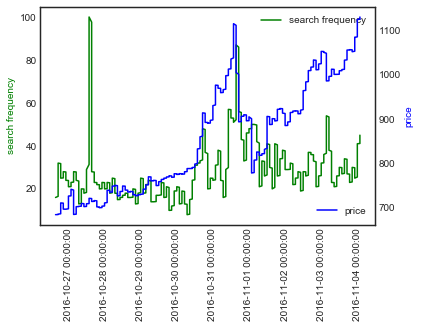

In [14]:
#bitcoin price and search frequency

x = df.date
y1 =pd.rolling_mean(df['bitcoin'], window = 30)
y2 =pd.rolling_mean(df['Close'], window = 30)




fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.legend(['search frequency'], loc=1)
ax2.legend(['price'],loc=4)

ax1.set_ylabel('search frequency', color='g')
ax2.set_ylabel('price', color='b')

ax1.set_xticklabels(labels=bitinterest.date,rotation = 90)

plt.show()


# NLP
1. topic modeling with NMF
2. sentiment analysis with Vader
3. more topic modeling according to sentiment score


In [15]:
twittertxt = df[['date','cleanedtweet']]
twittertxt.head()


,date,cleanedtweet
0,2016-10-27,price
1,2016-10-27,iceland days icelandic pirate party lead bet g...
2,2016-10-27,easy easy easy mining cloud miner
3,2016-10-27,based social media community system
4,2016-10-27,may found winning answer privacy


In [16]:
#lemmatization & tokenizing at one step
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

twittertxt['lemmatweet'] =twittertxt['cleanedtweet'].apply(lemmatize_text)

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1. topic modeling - NMF

In [17]:
#Tfidf to vecotize text for NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
slist = ['market','current','money','via','news','post','price','average','chain','new','chinese']
tfid = TfidfVectorizer(stop_words=slist, max_df = 0.8)
#max_df = 0.85,min_df = 0.05,stop_words =slist
transtweet = tfid.fit_transform(twittertxt['cleanedtweet'])


In [18]:
#extract popular topics from vectorized text
#depends on the cicle of price, n_components = 6
nmf = NMF(n_components = 6)
nmftopic = nmf.fit_transform(transtweet)

In [19]:
#group dataframe into trading cycles according to price(over 5 days consecutive price increase or drop) to get a sense of topic over time
#cycle1: 2016/10/27 - 2016/12/02 -fluctuation
#cycle2: 2016/12/03 - 2017/01/04 -up
#cycle3: 2017/01/05 - 2017/01/11 -down
#cycle4: 2017/01/12 - 2017/01/20 -up
#cycle5: 2017/01/21 - 2017/02/08 -up
#cycle6: 2017/02/09 - 2017/02/22 -up

#create a new columns called 'cycle in nmfdf in order to groupby cycles
df['cycle'] = 1
       
cycles = ['2016/10/27','2016/12/03','2017/01/05','2017/01/12','2017/01/21','2017/02/09']
for cycleid, cycle in enumerate(cycles):
    df.loc[df['date'] >= cycle, 'cycle'] = cycleid+1

#grouped date into different cycles
df.head()

,date,cleanedtweet,bitcoin,nem,isPartial,Open,High,Low,Close,Volume (Currency),Weighted Price,cycle
0,2016-10-27,price,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1
1,2016-10-27,iceland days icelandic pirate party lead bet g...,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1
2,2016-10-27,easy easy easy mining cloud miner,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1
3,2016-10-27,based social media community system,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1
4,2016-10-27,may found winning answer privacy,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1


In [20]:
#append nmftopic array into dataframe, so we have scores of each topic on one tweet
nmftopicdf = pd.DataFrame(nmftopic)
nmfdf = df.merge(nmftopicdf, left_index = True, right_index = True)

In [21]:
#calculate each topic's score over 6 trading cycles
nmfovercycle = nmfdf.groupby('cycle')[[0,1,2,3,4,5]].mean()
nmfovercycle

,0,1,2,3,4,5
cycle,,,,,,
1,0.001836,0.000831,0.002314,0.002096,0.002966,0.004248
2,0.001692,0.000920,0.002578,0.002876,0.003037,0.004083
3,0.001809,0.000754,0.002409,0.001955,0.004272,0.003800
4,0.001484,0.000734,0.001926,0.001614,0.003703,0.004141
5,0.001548,0.000822,0.002081,0.001783,0.003609,0.003899
6,0.001535,0.000381,0.002106,0.003689,0.003114,0.003858


In [22]:
#put vectorized popular topics back into text
def topictxt(model,feature_names, n_top_words):
    toptopics = {}
    for topicid, topic in enumerate(model.components_):
        message = "Topic #%d: " % topicid
        message += ",".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        toptopics[topicid] = ([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return toptopics


perform topic modeling over different cycles

In [23]:
#divid each data into cycle dataframe
c1df = df[df.cycle==1]
c2df = df[df.cycle==2]
c3df = df[df.cycle==3]
c4df = df[df.cycle==4]
c5df = df[df.cycle==5]
c6df = df[df.cycle==6]
cdflist = [c1df,c2df,c3df,c4df,c5df,c6df]
c4df.head()

,date,cleanedtweet,bitcoin,nem,isPartial,Open,High,Low,Close,Volume (Currency),Weighted Price,cycle
409052,2017-01-12,retirement income provide mix stocks business,50,12,False,778.7,832.99,751.34,807.47,1.363225e+07,783.456353,4
409053,2017-01-12,julian read block hash prove alive,50,12,False,778.7,832.99,751.34,807.47,1.363225e+07,783.456353,4
409054,2017-01-12,video bounty video review,50,12,False,778.7,832.99,751.34,807.47,1.363225e+07,783.456353,4
409055,2017-01-12,video bounty news,50,12,False,778.7,832.99,751.34,807.47,1.363225e+07,783.456353,4
409056,2017-01-12,extremely volatile,50,12,False,778.7,832.99,751.34,807.47,1.363225e+07,783.456353,4


In [24]:
for i, cdf in enumerate(cdflist):
    slist = ['market','current','money','via','news','post','price','average','chain','new','chinese']
    tfid = TfidfVectorizer(stop_words=slist, max_df = 0.8)
    transtweet = tfid.fit_transform(cdf['cleanedtweet'])
    nmf = NMF(n_components  = 1)
    nmftopic = nmf.fit_transform(transtweet)

    feature_names = tfid.get_feature_names()
    nmftopictxt = topictxt(nmf,feature_names,12)
    print(i+1, nmftopictxt)

1 {0: ['buy', 'sell', 'india', 'instantly', 'potential', 'try', 'currency', 'us', 'digital', 'exchange', 'trading', 'get']}
2 {0: ['buy', 'high', 'currency', 'year', 'time', 'first', 'cap', 'one', 'billion', 'worth', 'gold', 'digital']}
3 {0: ['china', 'bank', 'central', 'currency', 'exchange', 'high', 'another', 'warning', 'percent', 'yuan', 'rational', 'investment']}
4 {0: ['china', 'trading', 'bank', 'central', 'exchange', 'margin', 'buy', 'currency', 'digital', 'india', 'us', 'business']}
5 {0: ['buy', 'trading', 'make', 'exchange', 'sell', 'china', 'great', 'gold', 'mining', 'use', 'start', 'today']}
6 {0: ['bank', 'china', 'central', 'buy', 'first', 'trading', 'exchange', 'currency', 'digital', 'vienna', 'warning', 'top']}


2.Sentiment analysis with NLTK

In [25]:
#!pip install --upgrade vaderSentiment
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [26]:
analyzer =  SentimentIntensityAnalyzer()
postivesentiment = []
negativesentiment = []
neutralsentiment = []


for i in range(df.shape[0]):
    sent_dict = analyzer.polarity_scores(df.iloc[i, 1])
    
    postivesentiment.append(sent_dict['pos'])
    negativesentiment.append(sent_dict['neg'])
    neutralsentiment.append(sent_dict['neu'])


In [27]:
#append sentiment score to df
df['pos']  = postivesentiment
df['neg'] = negativesentiment
df['neu'] = neutralsentiment
df.head()

,date,cleanedtweet,bitcoin,nem,isPartial,Open,High,Low,Close,Volume (Currency),Weighted Price,cycle,pos,neg,neu
0,2016-10-27,price,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1,0.000,0.0,1.000
1,2016-10-27,iceland days icelandic pirate party lead bet g...,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1,0.252,0.0,0.748
2,2016-10-27,easy easy easy mining cloud miner,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1,0.744,0.0,0.256
3,2016-10-27,based social media community system,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1,0.000,0.0,1.000
4,2016-10-27,may found winning answer privacy,16,12,False,674.63,685.89,665.59,684.71,3.090090e+06,679.822527,1,0.459,0.0,0.541


/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30000).mean()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30000).mean()



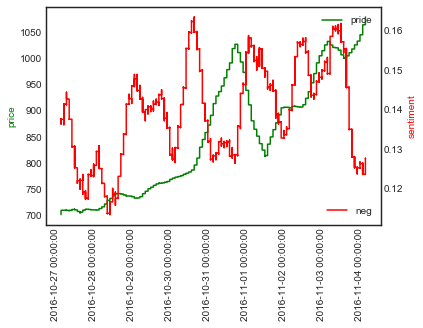

In [28]:
#price and negative sentiment
x = df.date
y1 = pd.rolling_mean(df['Close'], window = 30000)
y2 = pd.rolling_mean(df['neg'].apply(lambda x: x*2), window = 30000)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'r-')
ax1.legend(['price'], loc=1)
ax2.legend(['neg'],loc=4)
ax1.set_ylabel('price', color='g')
ax2.set_ylabel('sentiment', color='r')
ax1.set_xticklabels(labels=bitinterest.date,rotation = 90)

plt.show()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30000).mean()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=30000).mean()



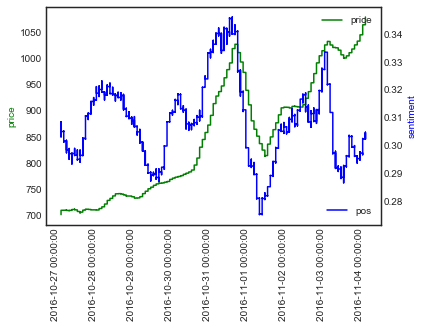

In [29]:
#price and positive sentiment
x = df.date
y1 = pd.rolling_mean(df['Close'], window = 30000)
y2 = pd.rolling_mean(df['pos'].apply(lambda x: x*2), window = 30000)


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()


ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')


ax1.legend(['price'], loc=1)
ax2.legend(['pos'],loc=4)


ax1.set_ylabel('price', color='g')
ax2.set_ylabel('sentiment', color='b')


ax1.set_xticklabels(labels=bitinterest.date,rotation = 90)

plt.show()

Topic by sentiment

In [30]:
posdf = df[df['pos']>=0.3]
negdf = df[df['neg']>0]


In [31]:
#extract topic from negative sentiment scores over the entire cycle

#slist = ['market','current','money','via','news','post','price','average','chain','new','chinese']
tfid = TfidfVectorizer(max_df = 0.8)
#max_df = 0.85,min_df = 0.05,stop_words =slist
transtweet = tfid.fit_transform(negdf['cleanedtweet'])
nmf = NMF(n_components = 6)
nmftopic = nmf.fit_transform(transtweet)

feature_names = tfid.get_feature_names()
topictxt(nmf,feature_names,10)


{0: ['height',
  'block',
  'new',
  'size',
  'post',
  'chain',
  'debate',
  'user',
  'proposal',
  'miner'],
 1: ['low',
  'high',
  'billion',
  'cap',
  'worth',
  'market',
  'one',
  'risk',
  'year',
  'new'],
 2: ['insane',
  'garden',
  'every',
  'bonanza',
  'day',
  'giveaway',
  'crushed',
  'currency',
  'rally',
  'running'],
 3: ['via',
  'stolen',
  'block',
  'millions',
  'hard',
  'phone',
  'scam',
  'size',
  'unconfirmed',
  'buy'],
 4: ['pay',
  'ransom',
  'buy',
  'invest',
  'mobile',
  'data',
  'us',
  'money',
  'check',
  'cash'],
 5: ['news',
  'price',
  'china',
  'chinese',
  'currency',
  'demand',
  'bank',
  'warning',
  'ban',
  'stop']}

# Word2vec


In [32]:
import gensim
from sklearn.manifold import TSNE

In [33]:
text = twittertxt['lemmatweet']
word2vec = gensim.models.Word2Vec(text, size=30, window=5, min_count=1, workers=2,sg=0)


In [34]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in word2vec.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x: -x[2])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
# create a DataFrame with the word2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(word2vec.wv.syn0[:],
                            index=ordered_terms)

word_vectors.head()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning:

Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
via,0.492644,-0.480483,1.131157,0.187265,0.868602,0.383264,1.561964,0.730717,0.705380,0.263159,...,0.495979,0.405591,0.459160,0.207476,0.080502,-0.261543,1.060016,-0.939116,0.285152,0.124828
price,2.756889,-0.059084,1.385435,0.907404,1.482720,0.032620,-1.081743,-0.634274,0.454149,0.454668,...,1.760209,-0.704275,1.655499,-0.317319,-0.303047,-1.512405,3.189082,-1.069868,0.496587,0.887804
new,0.605633,1.099680,2.871596,0.029848,1.691675,-0.897587,1.306533,0.534151,-0.264890,0.122265,...,1.669843,0.534591,-2.023095,1.138928,1.594780,0.312395,1.334319,-0.845132,0.926713,-0.453684
news,-0.353859,-0.254263,1.225439,0.371203,-0.055266,-0.066967,1.588823,0.204792,1.153363,1.097926,...,0.389038,0.355406,0.656160,1.010330,0.551716,-0.242350,1.135965,-0.614804,1.048141,0.150525
money,-0.762513,0.937883,-0.707667,-2.143603,-0.727525,-1.448830,1.323898,3.186796,-1.816924,-0.866529,...,0.048771,-0.330018,1.327720,2.013140,-0.234396,-0.318673,0.225764,-2.418833,-0.730093,-0.159020


In [35]:
#get the related words with each word

def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in word2vec.most_similar(positive=[token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [36]:
get_related_terms(u'china')

chinese              0.84
continue             0.713
quartz               0.703
india                0.701
indian               0.663
halt                 0.663
rupee                0.651
onshore              0.641
gain                 0.635
devaluation          0.628


/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



In [37]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = word2vec.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [38]:
word_algebra(add=[u'trump', u'price'])

trigger


/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



In [39]:
word_algebra(subtract=[u'world', u'hacking'])

revelry


/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



# TSNE visualization

In [40]:
text = twittertxt['lemmatweet']
word2vec = gensim.models.Word2Vec(text, size=30, window=5, min_count=1, workers=2,sg=0)
word_vectors = pd.DataFrame(word2vec.wv.syn0[:],
                            index=ordered_terms)

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning:

Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).



In [41]:
tsne_input = word_vectors

tsne = TSNE()
tsne_vectors = tsne.fit_transform(tsne_input.values)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])
tsne_vectors.head()

,x_coord,y_coord
via,26.862755,21.526138
price,28.861856,-21.369093
new,26.736029,21.558296
news,26.884504,21.606783
money,53.373787,9.045277


In [42]:
tsne_vectors[u'word'] = tsne_vectors.index

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import itertools as it
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import _pickle as pickle
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
import matplotlib.pyplot as plt
%matplotlib inline
output_notebook()

from subprocess import check_output

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

Loading BokehJS ...

In [44]:
def clusterlist(countryname):
    l = countryname
    for i in range(2):
        newl = []
        for w in l:
            newl.extend([q[0] for q in word2vec.most_similar(w)])
        l+=list(set(newl))
        l = list(set(l))
    return l



In [45]:
#covert the list into a dataframe
morallist = clusterlist(['china'])
#chinalist = clusterlist(['china'])
hackinglist = clusterlist(['increase'])

#look up the list of words most similar to keyword, and construct a vector dataframe
moralvec = tsne_vectors.loc[morallist]
moralvec['color'] = 'red'
hackingvec = tsne_vectors.loc[hackinglist]
hackingvec['color']='blue'


/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



In [46]:
# countryvec = chinavec.append(icelandvec)
# countryvec = countryvec.append(indiavec)
allvec = moralvec.append(hackingvec)

In [47]:
allvec = allvec[['x_coord','y_coord','color']]
allvec.head()

,x_coord,y_coord,color
worsen,5.302780,2.827301,red
gove,8.089390,0.804401,red
investigate,35.596806,21.380705,red
structural,25.139372,2.095107,red
lower,29.466406,-21.492182,red


In [48]:
allvec[u'word'] = allvec.index

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
output_notebook()

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(allvec)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips =  u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'color', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

Loading BokehJS ...

# Time series analysis 

1. LSTM

In [49]:
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas import tseries
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from pandas.tools.plotting import autocorrelation_plot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import plotly.offline as py
import plotly.graph_objs as go

import seaborn as sns
py.init_notebook_mode(connected=True)

/Users/windflower715/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [50]:
nmftopicdf = pd.DataFrame(nmftopic)
nmfdf = df.merge(nmftopicdf, left_index = True, right_index = True)

In [51]:
#reconstruct df to contain only X and Y

newdf = df[['date','cleanedtweet','bitcoin','nem','Close','pos','neg','neu']].merge(nmfdf[['cleanedtweet',0,1,2,3,4,5]], on = 'cleanedtweet')
newdf =newdf.groupby('date')[['bitcoin','nem','Close','pos','neg','neu',0,1,2,3,4,5]].mean()
newdf.head()

#bitcoin, nem is the search frequency for bitcoin and nem during the day 
#close is closing bitcoin price 
#pos,neg, neu is sentiment score
#0,1,2,3,4,5 is nmf topic vectors

,bitcoin,nem,Close,pos,neg,neu,0,1,2,3,4,5
date,,,,,,,,,,,,
2016-10-27,16,12,684.71,0.121624,0.020089,0.858287,0.003813,0.003096,0.001729,0.005072,0.003783,0.011197
2016-10-28,32,2,685.91,0.117055,0.021870,0.861075,0.003731,0.003556,0.001751,0.005076,0.003908,0.011157
2016-10-29,25,5,711.13,0.137984,0.020164,0.841851,0.003732,0.003739,0.001814,0.005215,0.004075,0.011042
2016-10-30,28,12,697.23,0.136934,0.044867,0.818198,0.003768,0.003445,0.001879,0.005445,0.004015,0.010919
2016-10-31,24,6,697.01,0.125163,0.040928,0.833909,0.003780,0.003194,0.002119,0.005438,0.004078,0.010869


In [58]:
newdf['t1']=newdf.Close.shift(1)
newdf['t2'] = newdf.Close.shift(2)
newdf['t3'] = newdf.Close.shift(3)
newdf.dropna(inplace = True)
newdf.head()



,bitcoin,nem,Close,pos,neg,neu,0,1,2,3,4,5,t1,t2,t3
date,,,,,,,,,,,,,,,
2016-10-30,28,12,697.23,0.136934,0.044867,0.818198,0.003768,0.003445,0.001879,0.005445,0.004015,0.010919,711.13,685.91,684.71
2016-10-31,24,6,697.01,0.125163,0.040928,0.833909,0.003780,0.003194,0.002119,0.005438,0.004078,0.010869,697.23,711.13,685.91
2016-11-01,21,3,726.60,0.122251,0.030868,0.846880,0.003891,0.003305,0.002018,0.005420,0.004073,0.010954,697.01,697.23,711.13
2016-11-02,23,6,742.00,0.117029,0.033326,0.849643,0.004136,0.003409,0.002071,0.005542,0.004071,0.010990,726.60,697.01,697.23
2016-11-03,28,5,685.22,0.112092,0.035626,0.852281,0.004376,0.003529,0.002027,0.005358,0.003864,0.010988,742.00,726.60,697.01


In [59]:
Ytrain = newdf['Close'][:83]
Ytest =  newdf['Close'][83:]
Xtrain = newdf[['bitcoin','nem','pos','neg','neu','t1','t2',0,1,2,3,4,5]][:83]
Xtest = newdf[['bitcoin','nem','pos','neg','neu','t1','t2',0,1,2,3,4,5]][83:]


In [60]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler_train = MinMaxScaler(feature_range=(-1, 1))
scaler_test = MinMaxScaler(feature_range=(-1, 1))

def preprocess(data):
    rows = data.shape[0]
    columns = data.shape[1]
    data = data.values.reshape(-1,1).astype('float32')
    data = scaler.fit_transform(data)
    data= data.reshape(rows,columns)
    return data

In [61]:
trainX = preprocess(Xtrain)
testX = preprocess(Xtest)
trainY = scaler_train.fit_transform(Ytrain.values.reshape(-1,1))
testY = scaler_test.fit_transform(Ytest.values.reshape(-1,1))

In [62]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(83, 1, 13) (83, 1) (33, 1, 13) (33, 1)


In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [64]:
yhat = model.predict(testX)

yhat_inverse = scaler_test.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler_test.inverse_transform(testY.reshape(-1, 1))
 
trainY_inverse  = scaler_train.inverse_transform(trainY.reshape(-1,1))

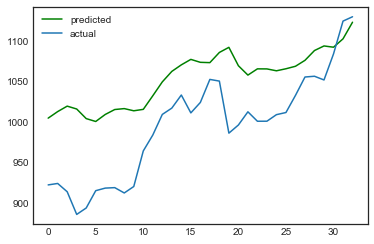

In [65]:
plt.plot(yhat_inverse, label='predicted', color = 'green')
plt.plot(testY_inverse, label='actual')


plt.legend()
plt.show()

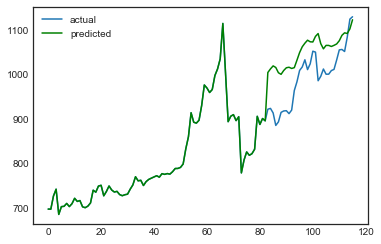

In [66]:
a =trainY_inverse.tolist()+testY_inverse.tolist()
plt.plot(a, label = 'actual')
n = len(trainY)

plt.plot(trainY_inverse.tolist()+yhat_inverse.tolist(),label = 'predicted', color = 'green')
plt.legend()